# Jellyfish_Classification
---
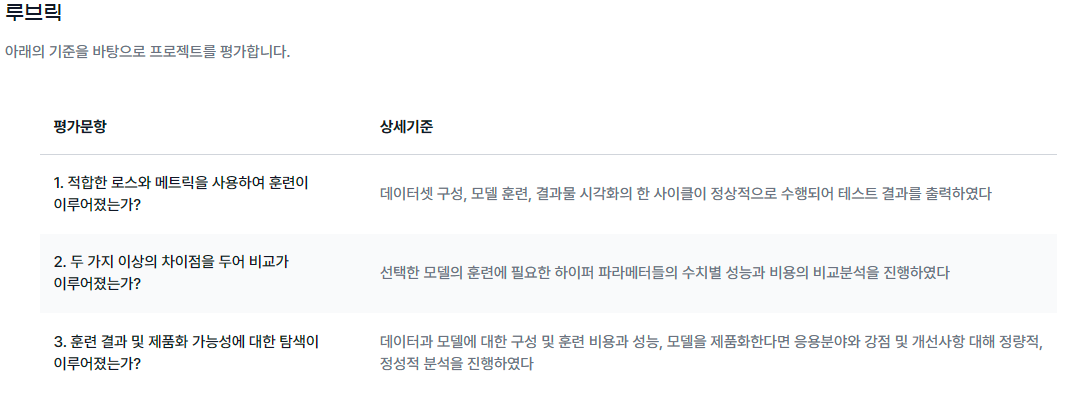

---
### DL_Thon Team Project
### 1조 / 해파리구분해조
### 팀원
- 김민기
- 강영현
- 조수민
- 오우진


## 목차
---
### 1. 데이터 구성 확인
### 2. 데이터 증강 시도
    - object detection
### 3. 모델 선정
    - W&B 캡쳐
### 4. 모델 개선 결과
### #. 회고

---
## 1. 데이터 구성 확인

- 학습 데이터 불러오기

blue_jellyfish


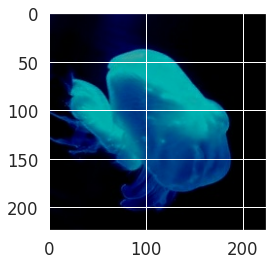

In [50]:
import tensorflow as tf
import os

# 그림 디코더
def decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, [224,224])
    return img

file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'Train')
file_list = os.listdir(file_path)
file_list

x_train = []
y_train_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        img_path = os.path.join(file_path, i, j)
        x_train.append(decode_img(img_path))
        y_train_name.append(i)
        
import matplotlib.pyplot as plt

print(y_train_name[610])
plt.imshow(x_train[610])

- 학습 데이터 클래스 개수 확인

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

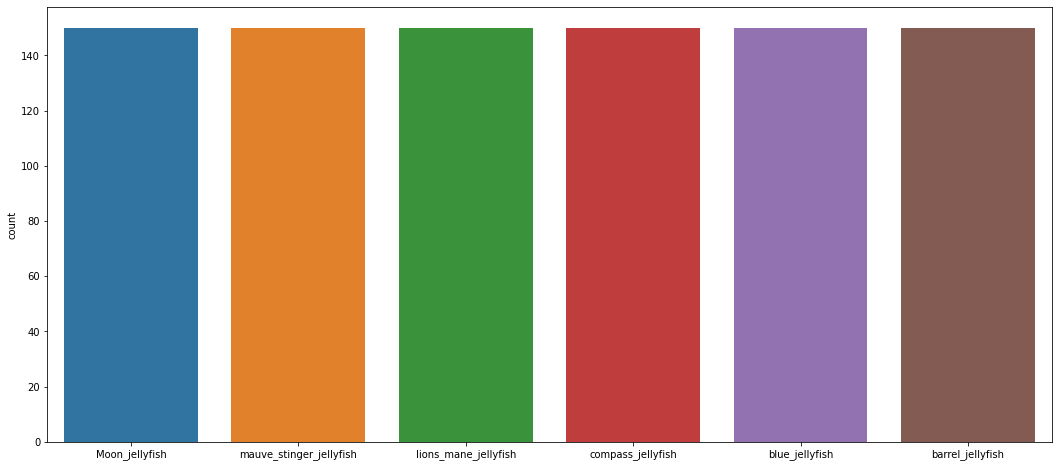

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,8))
sns.countplot(y_train_name)

- 클래스 별로 동일한 데이터 개수를 가진 것을 확인할 수 있다.

---
- Validation data 불러오기

mauve_stinger_jellyfish


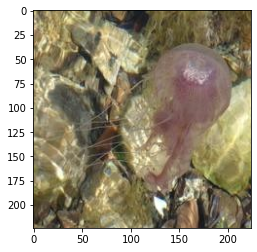

In [5]:
file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'valid')
file_list = os.listdir(file_path)
file_list

x_valid = []
y_valid_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        img_path = os.path.join(file_path, i, j)
        x_valid.append(decode_img(img_path))
        y_valid_name.append(i)
        
import matplotlib.pyplot as plt

print(y_valid_name[10])
plt.imshow(x_valid[10])

---
- test data 불러오기

mauve_stinger_jellyfish


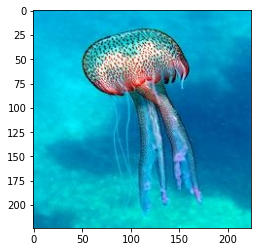

In [6]:
file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'test')
file_list = os.listdir(file_path)
file_list

x_test = []
y_test_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        img_path = os.path.join(file_path, i, j)
        x_test.append(decode_img(img_path))
        y_test_name.append(i)
        
import matplotlib.pyplot as plt

print(y_test_name[10])
plt.imshow(x_test[10])

---
### 데이터 전처리

In [7]:
# 팀프로젝트인 만큼 name 클래스 통일

name_dict = {'Moon_jellyfish' : 0,
'mauve_stinger_jellyfish' : 1,
'lions_mane_jellyfish' : 2,
'compass_jellyfish' : 3,
'blue_jellyfish' : 4,
'barrel_jellyfish' : 5}

In [12]:
# y데이터 정수 라벨링/ 배열로 변환
y_train = list(map(lambda x: name_dict[x], y_train_name))
y_valid = list(map(lambda x: name_dict[x], y_valid_name))
y_test = list(map(lambda x: name_dict[x], y_test_name))

y_train = np.array(y_train).reshape(-1).astype('float')
y_valid = np.array(y_valid).reshape(-1).astype('float')
y_test = np.array(y_test).reshape(-1).astype('float')

In [60]:
# x데이터 배열로 변환
import numpy as np

x_train = np.array(x_train).reshape(-1, 224, 224, 3)
x_valid = np.array(x_valid).reshape(-1, 224, 224, 3)
x_test = np.array(x_test).reshape(-1, 224, 224, 3)

- 데이터 확인

In [61]:
x_train.shape, x_valid.shape, x_test.shape

((900, 224, 224, 3), (39, 224, 224, 3), (40, 224, 224, 3))

In [14]:
y_train.shape, y_valid.shape, y_test.shape

((900,), (39,), (40,))

---
## 2. 데이터 증강시도

- 실제 데이터 증강이 된 부분을 확인할 수 있어 이미지 제너레이터를 활용한 방법은 따로 진행하지 않았다.

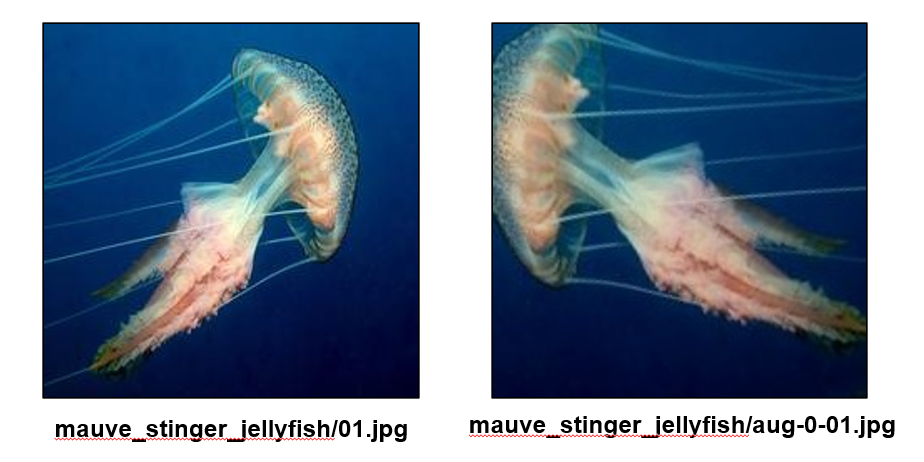

- Object Detection을 활용하여 사진 가공하기

In [15]:
!pip3 install --upgrade tensorflow

In [16]:
!pip install --upgrade tensorflow_hub

In [17]:
!pip3 install tensorflow-estimator

- Efficientdet/lite3-detection 모델 불러오기

In [21]:
# Apply image detector on a single image.
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite3-detection/versions/1"
detector = hub.load(hub_url)

- Detection이 잡혔을 때 가장 큰 크기의 그림을 추출하여 224,224,3 사이즈로 통일한다.
- 만약, Detection이 잡히지 않는다면 원본 데이터를 가져올 수 있도록 메써드를 구성한다

In [22]:
import cv2
import numpy as np
import tensorflow as tf
import os

def get_sub_images(image_path, score_threshold=0.35):
    img = cv2.imread(image_path)
    IMG_SIZE = [img.shape[1], img.shape[0]]
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_ori = img.copy()
    img = tf.constant(img, dtype=tf.uint8)
    img = tf.expand_dims(img, axis=0)
    img = img.numpy()
    boxes, scores, classes, num_detections = detector(img)
    objects = 0
    images = []

    for i in range(num_detections[0]):
        if scores[0][i] >= score_threshold:
            box = boxes[0][i]
            y_min, x_min, y_max, x_max = box

            cv2.rectangle(img_ori, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            boxed_region = img_ori[int(y_min):int(y_max), int(x_min):int(x_max)]
            if not 0 in boxed_region.shape:        
                images.append(np.squeeze(boxed_region))
#                 objects += 1

    if len(images) == 0:
        return_img = np.squeeze(img_ori)
        return_img = cv2.resize(return_img, (224,224), interpolation=cv2.INTER_LINEAR)
    elif len(images) == 1:
        return_img = images[0]
        return_img = cv2.resize(return_img, (224,224), interpolation=cv2.INTER_LINEAR)
        
    else:
        numbers = []
        for i in images :
            number = i.shape[0]*i.shape[1]
            numbers.append(number)
        
        return_img = images[numbers.index(max(numbers))]
        return_img = cv2.resize(return_img, (224,224), interpolation=cv2.INTER_LINEAR)
    
    return_img = return_img/255
    
    return return_img

- 단, 증강한 파일은 제외한 채 진행한다

In [25]:
import os

file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'Train')
file_list = os.listdir(file_path)
file_list

x_train_ob = []
y_train_ob_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        if not'aug' in j :
            img_path = os.path.join(file_path, i, j)
            x_train_ob.append(get_sub_images(img_path))
            y_train_ob_name.append(i)

In [23]:
file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'test')
file_list = os.listdir(file_path)
file_list

x_test_ob = []
y_test_ob_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        if not'aug' in j :
            img_path = os.path.join(file_path, i, j)
            x_test_ob.append(get_sub_images(img_path))
            y_test_ob_name.append(i)

In [26]:
file_path = os.path.join(os.getcwd(), 'jellyfish', 'Train_Test_Valid', 'valid')
file_list = os.listdir(file_path)
file_list

x_valid_ob = []
y_valid_ob_name = []
for i in file_list:
    for j in os.listdir(os.path.join(file_path, i)):
        if not'aug' in j :
            img_path = os.path.join(file_path, i, j)
            x_valid_ob.append(get_sub_images(img_path))
            y_valid_ob_name.append(i)

- 원본 이미지 vs 디텍션으로 가공된 이미지

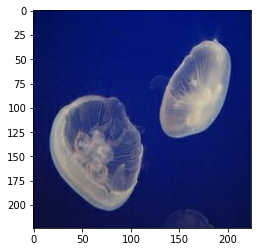

In [27]:
plt.imshow(x_test[3])

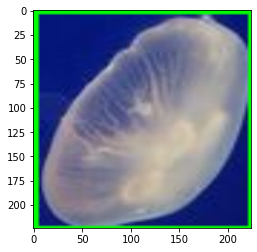

In [28]:
plt.imshow(x_test_ob[3])

In [29]:
# y데이터 정수 라벨링/ 배열로 변환

y_train_ob = list(map(lambda x: name_dict[x], y_train_ob_name))
y_test_ob = list(map(lambda x: name_dict[x], y_test_ob_name))
y_valid_ob = list(map(lambda x: name_dict[x], y_valid_ob_name))

y_train_ob = np.array(y_train_ob).reshape(-1).astype('float')
y_valid_ob = np.array(y_valid_ob).reshape(-1).astype('float')
y_test_ob = np.array(y_test_ob).reshape(-1).astype('float')

In [30]:
# x데이터 배열로 변환
import numpy as np

x_train_ob = np.array(x_train_ob).reshape(-1, 224, 224, 3)
x_valid_ob = np.array(x_valid_ob).reshape(-1, 224, 224, 3)
x_test_ob = np.array(x_test_ob).reshape(-1, 224, 224, 3)

---

## 3. 모델선정

In [31]:
!pip install wandb==0.16.0

In [32]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [33]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key = '7ca5c12a65d376ab30d3e32c2ade73e73f77e088')

sweep_config = {
    "name": "Xception",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.0001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 2,
            "max" : 4
            }
                    
        }
    }

wandb: Currently logged in as: uilove216. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


In [34]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

- 일반 데이터용 train 메서드

In [35]:
def train():
    default_config = {
        "input" : (224,224,3),
#         "filter" : 16,
#         "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    CLASS_NAMES = [0, 1, 2, 3, 4, 5]
    # Model
    base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=config.input)
    # Freeze the convolutional layers
    for layer in base_model.layers[:-3]:
        layer.trainable = False
        
    model=tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(x_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (x_valid, y_valid),
              callbacks = [WandbCallback(validation_data = (x_test, y_test),
                                        lables = CLASS_NAMES, #0~5
                                        predictions = 6,
                                        input_type = "images")])
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [36]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_dlthon',
                       project = 'classification_jelly_fish')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=2)

Create sweep with ID: 7wky713v
Sweep URL: https://wandb.ai/aiffel_dlthon/classification_jelly_fish/sweeps/7wky713v


wandb: Agent Starting Run: sw2563on with config:
wandb: 	epoch: 4
wandb: 	learning_rate: 0.06508747931777334
wandb: Currently logged in as: uilove216 (aiffel_dlthon). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/4
1/1 [==============================] - 2s 2s/step- loss: 15.9313 - accuracy: 0.19


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_190132-sw2563on/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_190132-sw2563on/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_190132-sw2563on/files/model-best)... Done. 1.2s


29/29 [==============================] - 141s 5s/step - loss: 15.9313 - accuracy: 0.1956 - val_loss: 1.7879 - val_accuracy: 0.1795
Epoch 2/4
29/29 [==============================] - 123s 4s/step - loss: 1.8767 - accuracy: 0.1544 - val_loss: 1.7907 - val_accuracy: 0.1795
Epoch 3/4
29/29 [==============================] - 124s 4s/step - loss: 2.0064 - accuracy: 0.1533 - val_loss: 1.7957 - val_accuracy: 0.1282
Epoch 4/4
29/29 [==============================] - 122s 4s/step - loss: 1.9354 - accuracy: 0.1544 - val_loss: 1.7901 - val_accuracy: 0.1795
2/2 - 5s - loss: 1.7905 - accuracy: 0.1750 - 5s/epoch - 3s/step


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▁▁▁
epoch,▁▃▆█
loss,█▁▁▁
val_accuracy,██▁█
val_loss,▁▃█▃
Test Accuracy Rate:,17.5
Test Error Rate:,82.5
accuracy,0.15444
best_epoch,0


wandb: Agent Starting Run: jbau2ox4 with config:
wandb: 	epoch: 4
wandb: 	learning_rate: 0.02119721973145784


Epoch 1/4
1/1 [==============================] - 1s 1s/step- loss: 5.1427 - accuracy: 0.33


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_191118-jbau2ox4/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_191118-jbau2ox4/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_191118-jbau2ox4/files/model-best)... Done. 1.3s


29/29 [==============================] - 142s 5s/step - loss: 5.1427 - accuracy: 0.3300 - val_loss: 1.7130 - val_accuracy: 0.2821
Epoch 2/4
29/29 [==============================] - 121s 4s/step - loss: 1.8273 - accuracy: 0.2422 - val_loss: 2.9912 - val_accuracy: 0.2564
Epoch 3/4
29/29 [==============================] - 121s 4s/step - loss: 1.7507 - accuracy: 0.2056 - val_loss: 1.7546 - val_accuracy: 0.1795
Epoch 4/4
29/29 [==============================] - 123s 4s/step - loss: 1.6699 - accuracy: 0.2322 - val_loss: 2.0613 - val_accuracy: 0.2051
2/2 - 5s - loss: 1.7148 - accuracy: 0.2250 - 5s/epoch - 2s/step


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▃▁▃
epoch,▁▃▆█
loss,█▁▁▁
val_accuracy,█▆▁▃
val_loss,▁█▁▃
Test Accuracy Rate:,22.5
Test Error Rate:,77.5
accuracy,0.23222
best_epoch,0


---

- Object Detection용 train2 메서드

In [37]:
def train2():
    default_config = {
        "input" : (224,224,3),
#         "filter" : 16,
#         "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    CLASS_NAMES = [0, 1, 2, 3, 4, 5]
    # Model
    base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=config.input)
    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    model=tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(x_train_ob, y_train_ob,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (x_valid_ob, y_valid_ob),
              callbacks = [WandbCallback(validation_data = (x_test_ob, y_test_ob),
                                        lables = CLASS_NAMES, #0~5
                                        predictions = 6,
                                        input_type = "images")])
    
    test_loss, test_accuracy = model.evaluate(x_test_ob, y_test_ob, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [38]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_dlthon',
                       project = 'classification_jelly_fish')

# run the sweep
wandb.agent(sweep_id,
            function=train2,
            count=2)

Create sweep with ID: r8niezge
Sweep URL: https://wandb.ai/aiffel_dlthon/classification_jelly_fish/sweeps/r8niezge


wandb: Agent Starting Run: ze7ozjn7 with config:
wandb: 	epoch: 2
wandb: 	learning_rate: 0.03598658608393802


Epoch 1/2
1/1 [==============================] - 2s 2s/step- loss: 37.8408 - accuracy: 0.46


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best)... Done. 0.8s


10/10 [==============================] - 61s 6s/step - loss: 37.8408 - accuracy: 0.4608 - val_loss: 47.5715 - val_accuracy: 0.2308
Epoch 2/2
1/1 [==============================] - 1s 688ms/steposs: 29.7733 - accuracy: 0.71


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_192127-ze7ozjn7/files/model-best)... Done. 1.0s


10/10 [==============================] - 58s 6s/step - loss: 29.7733 - accuracy: 0.7179 - val_loss: 14.9746 - val_accuracy: 0.5897
2/2 - 5s - loss: 10.2029 - accuracy: 0.7250 - 5s/epoch - 2s/step


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁█
epoch,▁█
loss,█▁
val_accuracy,▁█
val_loss,█▁
Test Accuracy Rate:,72.5
Test Error Rate:,27.5
accuracy,0.71787
best_epoch,1


wandb: Agent Starting Run: fa601xy7 with config:
wandb: 	epoch: 3
wandb: 	learning_rate: 0.002537127473194534


Epoch 1/3
1/1 [==============================] - 1s 1s/step- loss: 2.1376 - accuracy: 0.50


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best)... Done. 0.8s


10/10 [==============================] - 61s 6s/step - loss: 2.1376 - accuracy: 0.5078 - val_loss: 1.0654 - val_accuracy: 0.5641
Epoch 2/3
10/10 [==============================] - 44s 4s/step - loss: 0.9037 - accuracy: 0.8339 - val_loss: 1.0711 - val_accuracy: 0.6667
Epoch 3/3
1/1 [==============================] - 1s 659ms/steposs: 0.2162 - accuracy: 0.94


/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_192345-fa601xy7/files/model-best)... Done. 1.0s


10/10 [==============================] - 58s 6s/step - loss: 0.2162 - accuracy: 0.9436 - val_loss: 0.9610 - val_accuracy: 0.6923
2/2 - 5s - loss: 0.7542 - accuracy: 0.7500 - 5s/epoch - 2s/step


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▆█
epoch,▁▅█
loss,█▄▁
val_accuracy,▁▇█
val_loss,██▁
Test Accuracy Rate:,75.0
Test Error Rate:,25.0
accuracy,0.94357
best_epoch,2


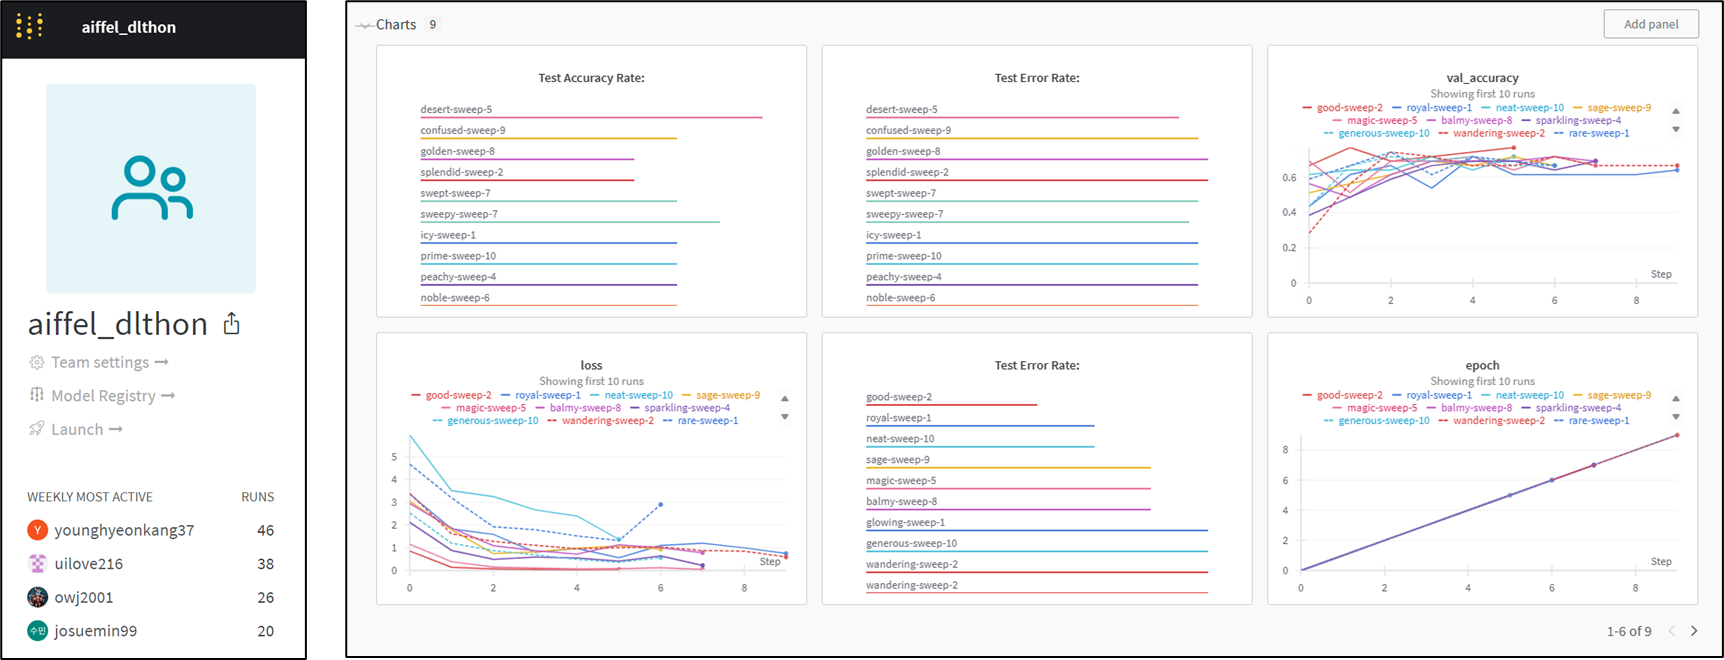

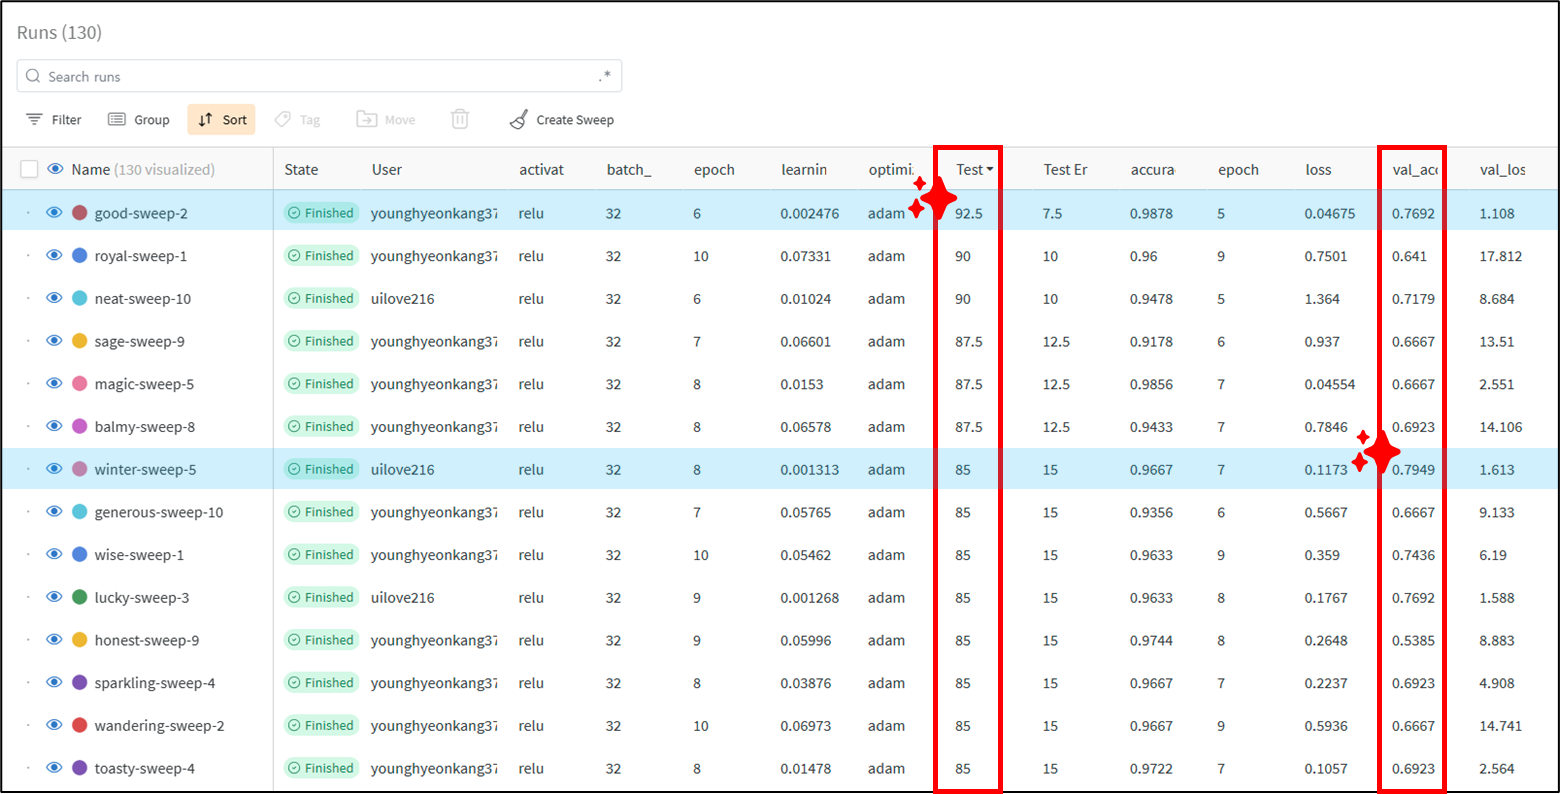

- 팀을 구성하고 총 130회 모델 학습 결과
---

- good-sweep-2 : DenseNet121 선정 : 가장 높은 Test Accuracy
- winter-sweep-5 : Xception 선정 : 가장 높은 Valid Accuracy

## 4. 모델 개선 결과

### good-sweep-2 : DenseNet121 선정 : 가장 높은 Test Accuracy

In [39]:
import tensorflow as tf
model_path = os.path.join(os.getcwd(), 'good-sweep-2.h5') # 변경필요
Dmodel = tf.keras.models.load_model(model_path)

#### 혼동행렬 그리기 : 현재 모델의 weak point를 찾는다

In [40]:
# 모델의 예측값 도출
y_pred = Dmodel.predict(x_train)   # x_test든 x_valid든 취사선택
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

29/29 [==============================] - 89s 3s/step


(900,)

                         precision    recall  f1-score   support

         Moon_jellyfish       1.00      1.00      1.00       150
mauve_stinger_jellyfish       1.00      1.00      1.00       150
   lions_mane_jellyfish       1.00      1.00      1.00       150
      compass_jellyfish       1.00      1.00      1.00       150
         blue_jellyfish       1.00      1.00      1.00       150
       barrel_jellyfish       1.00      1.00      1.00       150

               accuracy                           1.00       900
              macro avg       1.00      1.00      1.00       900
           weighted avg       1.00      1.00      1.00       900



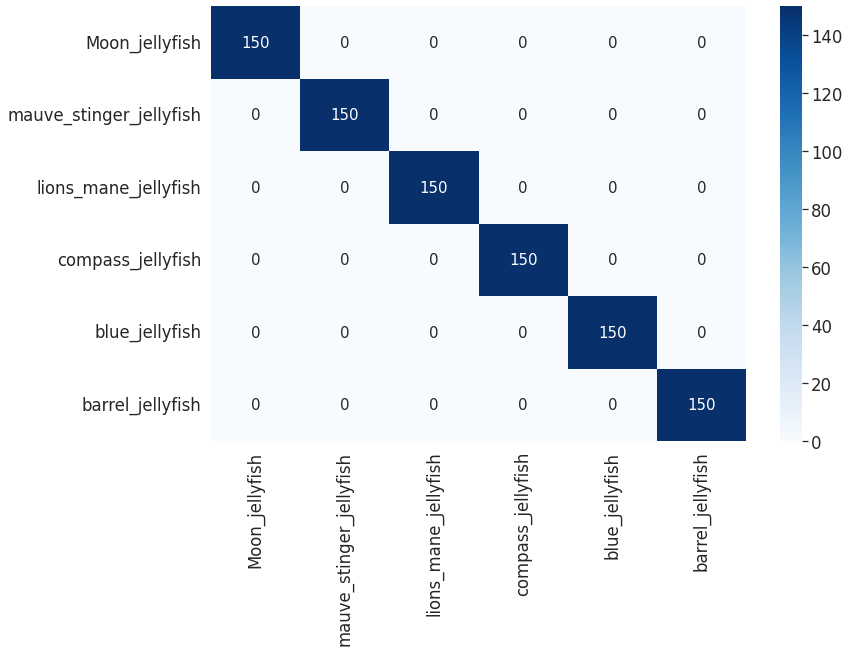

{'Moon_jellyfish': 0, 'mauve_stinger_jellyfish': 1, 'lions_mane_jellyfish': 2, 'compass_jellyfish': 3, 'blue_jellyfish': 4, 'barrel_jellyfish': 5}


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_train, y_pred, target_names=list(name_dict.keys())))
print('='*30)
conf = confusion_matrix(y_train, y_pred)  # 예측 시 넣었던 x_data에 맞추어

# 히트맵 그리기
flip_name_dic = {v: k for k, v in name_dict.items()}
annot_kws = {str(key): value for key, value in flip_name_dic.items()}
plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
sns.heatmap(conf, cmap='Blues', annot=True, fmt='d',
            xticklabels=list(name_dict.keys()),
            yticklabels=list(name_dict.keys()),
            annot_kws={'size': 15})
plt.show()
print('='*30)
print(name_dict)

#### 틀린 데이터 찾기
 - 비슷한 데이터를 추출하기 위함

In [46]:
wrong_array = y_train != y_pred
x_wrong = []
y_wrong = []
for idx, tf in enumerate(wrong_array):
    if tf:
        x_wrong.append(x_train[idx]) # 예측 시 넣었던 x_data에 맞추어
        y_wrong.append(y_train[idx])

x_wrong = np.array(x_wrong).reshape(-1, 224, 224, 3)
y_wrong = np.array(y_wrong).reshape(-1)
x_wrong.shape, y_wrong.shape

((0, 224, 224, 3), (0,))

In [45]:
for idx, i in enumerate(x_wrong):
    print(y_wrong[idx], '번인', flip_name_dic[y_wrong[idx]])
    if idx % 3 == 0:
        plt.figure(figsize=(15, 5))
    
    plt.subplot(1,3,idx % 3 +1)
    plt.imshow(i)
    
    if idx % 3 == 2:
        plt.show()

- blue_jellyfish의 데이터가 가장 많이 틀린 것으로 보인다

In [44]:
# 기존 모델 형태 확인
Dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

- 모델 accuracy 확인

In [47]:
Dmodel.evaluate(x_test, y_test)

2/2 [==============================] - 6s 704ms/step - loss: 0.4555 - accuracy: 0.9250


[0.45550522208213806, 0.925000011920929]

- 추가 데이터 삽입(blue_jellyfish)

In [48]:
add_path = os.path.join(os.getcwd(), 'jellyfish', 'add_blue_jellyfish')
add_list = os.listdir(add_path)

In [51]:
x_add = []
y_add = []

for i in add_list:
    if 'jpg' in i:
        img_path = os.path.join(add_path, i)
        x_add.append(decode_img(img_path))
        y_add.append(4)

x_add = np.array(x_add).reshape(-1, 224, 224, 3)
y_add = np.array(y_add).reshape(-1).astype('float')
x_add.shape, y_add.shape

((9, 224, 224, 3), (9,))

- 데이터 세팅 후 개선하기

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
Dmodel2 = tf.keras.models.clone_model(Dmodel)
Dmodel2.set_weights(Dmodel.get_weights())

for layer in Dmodel2.layers[-20:]:
    layer.trainable = True
    
Dmodel2.compile(optimizer=Adam(learning_rate=0.0000008),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
Dhistory = Dmodel2.fit(x_add, y_add, epochs=4, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/4
1/1 [==============================] - 41s 41s/step - loss: 5.6760 - accuracy: 0.0000e+00 - val_loss: 1.1136 - val_accuracy: 0.7692
Epoch 2/4
1/1 [==============================] - 9s 9s/step - loss: 5.1214 - accuracy: 0.0000e+00 - val_loss: 1.1196 - val_accuracy: 0.7692
Epoch 3/4
1/1 [==============================] - 7s 7s/step - loss: 4.7965 - accuracy: 0.2222 - val_loss: 1.1254 - val_accuracy: 0.7692


In [54]:
Dmodel2.evaluate(x_test, y_test)

2/2 [==============================] - 3s 592ms/step - loss: 0.4602 - accuracy: 0.9250


[0.4601546823978424, 0.925000011920929]

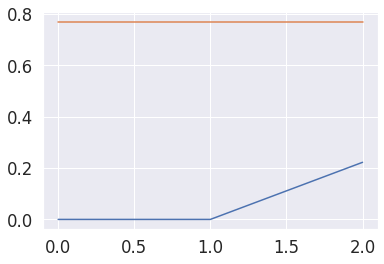

In [55]:
plt.plot(Dhistory.history['accuracy'])
plt.plot(Dhistory.history['val_accuracy'])

---
### Xception 선정 : 가장 높은 Valid Accuracy

In [56]:
import tensorflow as tf
model_path = os.path.join(os.getcwd(), 'winter-sweep-5.h5') # 변경필요
Xmodel = tf.keras.models.load_model(model_path)

In [62]:
# 모델의 예측값 도출
y_pred = Xmodel.predict(x_train)   # x_test든 x_valid든 취사선택
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

29/29 [==============================] - 101s 3s/step


(900,)

                         precision    recall  f1-score   support

         Moon_jellyfish       0.97      1.00      0.98       150
mauve_stinger_jellyfish       0.96      1.00      0.98       150
   lions_mane_jellyfish       0.95      0.98      0.97       150
      compass_jellyfish       1.00      0.99      0.99       150
         blue_jellyfish       0.99      0.91      0.95       150
       barrel_jellyfish       1.00      0.99      1.00       150

               accuracy                           0.98       900
              macro avg       0.98      0.98      0.98       900
           weighted avg       0.98      0.98      0.98       900



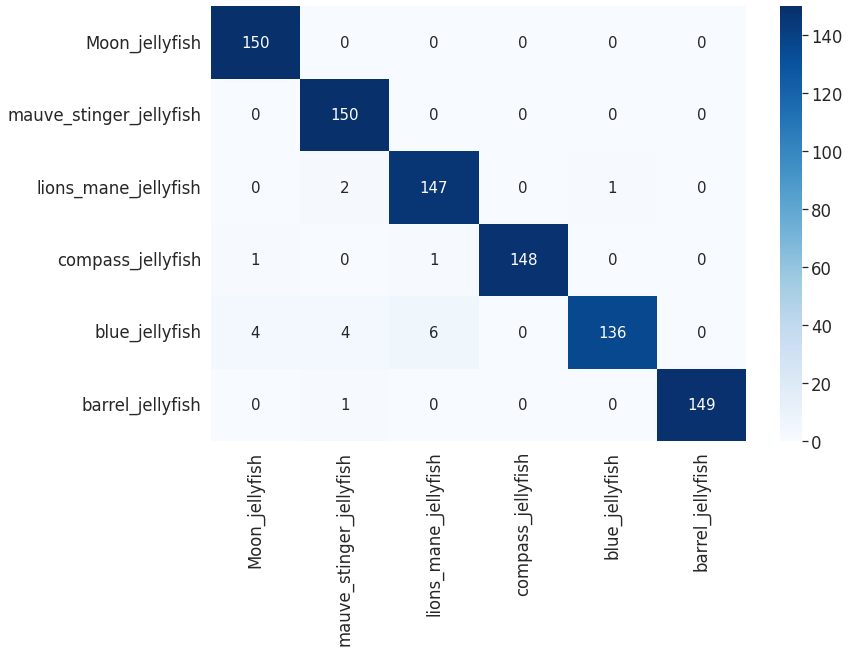

{'Moon_jellyfish': 0, 'mauve_stinger_jellyfish': 1, 'lions_mane_jellyfish': 2, 'compass_jellyfish': 3, 'blue_jellyfish': 4, 'barrel_jellyfish': 5}


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_train, y_pred, target_names=list(name_dict.keys())))
print('='*30)
conf = confusion_matrix(y_train, y_pred)  # 예측 시 넣었던 x_data에 맞추어

# 히트맵 그리기
flip_name_dic = {v: k for k, v in name_dict.items()}
annot_kws = {str(key): value for key, value in flip_name_dic.items()}
plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
sns.heatmap(conf, cmap='Blues', annot=True, fmt='d',
            xticklabels=list(name_dict.keys()),
            yticklabels=list(name_dict.keys()),
            annot_kws={'size': 15})
plt.show()
print('='*30)
print(name_dict)

### 틀린 데이터 찾기
 - 비슷한 데이터를 추출하기 위함

In [64]:
wrong_array = y_train != y_pred
x_wrong = []
y_wrong = []
for idx, tf in enumerate(wrong_array):
    if tf:
        x_wrong.append(x_train[idx]) # 예측 시 넣었던 x_data에 맞추어
        y_wrong.append(y_train[idx])

x_wrong = np.array(x_wrong).reshape(-1, 224, 224, 3)
y_wrong = np.array(y_wrong).reshape(-1)
x_wrong.shape, y_wrong.shape

((20, 224, 224, 3), (20,))

4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish


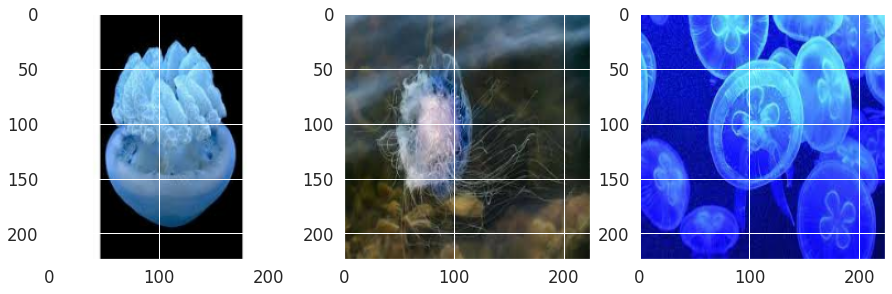

4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish


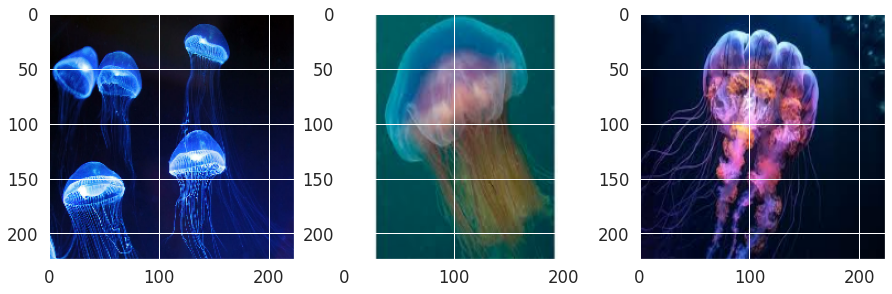

4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish
4.0 번인 blue_jellyfish


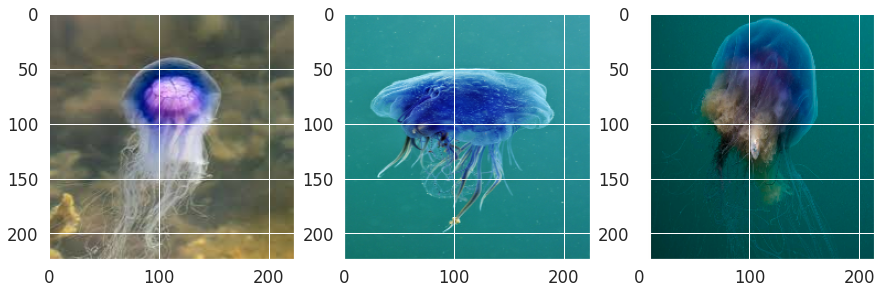

In [65]:
for idx, i in enumerate(x_add):
    print(y_add[idx], '번인', flip_name_dic[y_add[idx]])
    if idx % 3 == 0:
        plt.figure(figsize=(15, 5))
    
    plt.subplot(1,3,idx % 3 +1)
    plt.imshow(i)
    
    if idx % 3 == 2:
        plt.show()

- blue_jellyfish의 데이터가 가장 많이 틀린 것으로 보인다

In [67]:
# 기존 모델 형태 확인
Xmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
Xmodel2 = tf.keras.models.clone_model(Xmodel)
Xmodel2.set_weights(Xmodel.get_weights())

for layer in Xmodel2.layers[-4:]:
    layer.trainable = True
    
Xmodel2.compile(optimizer=Adam(learning_rate=0.0005133853948176324),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
Xhistory = Xmodel2.fit(x_add, y_add, epochs=2, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/2
1/1 [==============================] - 10s 10s/step - loss: 7.4368 - accuracy: 0.1111 - val_loss: 0.9471 - val_accuracy: 0.7436
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 2.6597 - accuracy: 0.3333 - val_loss: 0.9446 - val_accuracy: 0.7436


In [75]:
Xmodel2.evaluate(x_test, y_test)

2/2 [==============================] - 4s 773ms/step - loss: 0.3413 - accuracy: 0.8750


[0.3412855267524719, 0.875]

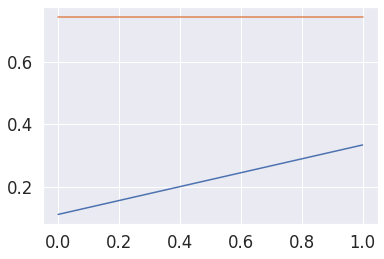

In [76]:
plt.plot(Xhistory.history['accuracy'])
plt.plot(Xhistory.history['val_accuracy'])

- 90퍼까지는 아니지만 개선된 모습
- 아래를 통해 실제 개선 시 모델을 그려봤다.

## 정확률 개선본

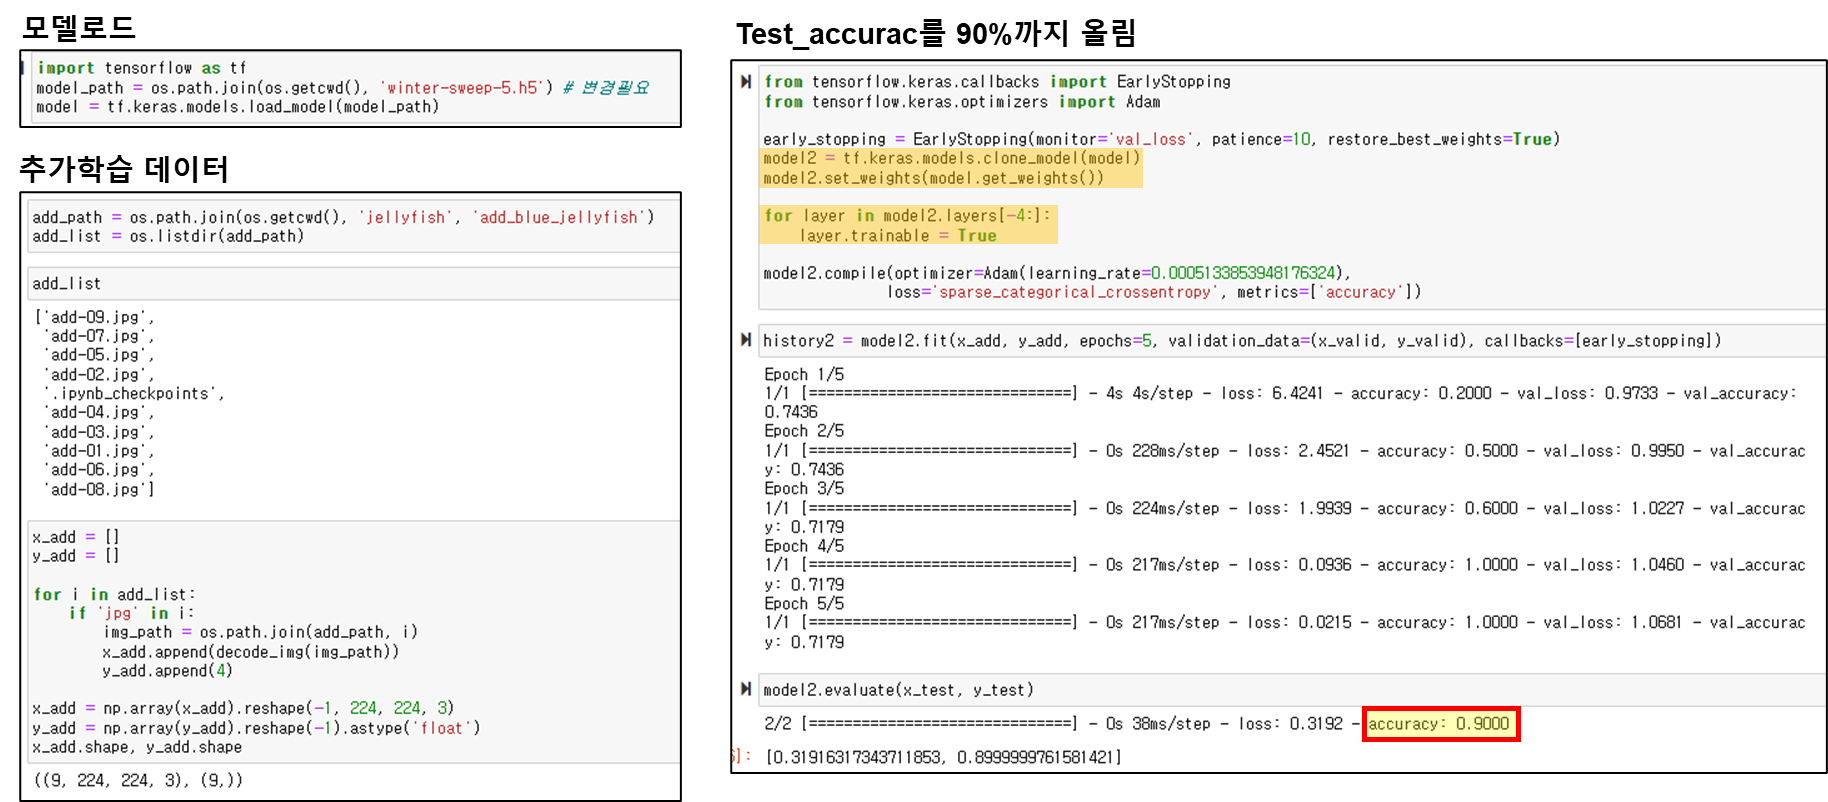

---

## #. 회고
### KEEP
- 김민기 : 갑작스레 조장을 맡게 되어 당황스러웠지만, 나름대로 오브젝트 디텍션을 시도해보는 등 다양한 시도를 해보려 노력해보았다.
- 강영현 : 새로운 모델을 이용해볼 수 있어서 좋았고, W&B가 생각보다 유용한 것 같아서 계속해서 사용해봐야겠다.
- 조수민 : 모델의 성능을 비교해볼 수 있어서 재밌었다. 구글링을 열심히 했다.
- 오우진 : 딥러닝 모델을 사용하여 해파리 이미지를 분류하고, Weights & Biases를 활용하여 하이퍼파라미터를 튜닝도하고 다양한 경험을 해서 좋았다

### PROBLEM
- 김민기 : 오브젝트 디텍션에서 가장 최신 기술인 YOLO V8을 통해 해파리일지언정 확실하게 잡아서, 좋은 데이터 증강 기법으로 사용하려 했으나, 코드에 대한 무지함덕에 이용하기가 너무 까다로웠고 시간이 부족해서 기존에 해봤던 object detection의 업그레이드 버전을 활용하게 되었다.
- 강영현 : 딥러닝에서 데이터셋이 굉장히 중요한 데, 데이터셋이 부족할 때 어떻게 해결해야 할지 아직 잘 모르는 것 같다. 코딩 실력이 아직 너무 부족해서 코딩을 하는 데 있어서도 많이 약한 것 같다. 공부해야될 것이 많은 것 같다.
- 조수민 : 데이터셋이 중요하다는 것을 많이 느꼈고 여전히 이해가 안되는 부분이 많다.
- 오우진 : 이제 딥러닝에 첫걸음을 시작한 것 같은데 프로젝트를 하면서 아직 모르는 것도 너무많고 실력이 부족한거 같다

### TRY
- 김민기 : model2=tf.keras.models.clone_model(model), model2.set_weights(model.get_weights()) 코드에서 어떻게 가중치를 불러오는 지 Chatgpt를 통해 잘알 수 있었다. 그래서 늦게나마 Transfer Learning을 진행하여 개선된 결과를 얻을 수 있었던 것 같다
- 강영현 : 지금까지 했던 프로젝트랑 퀘스트 모델들을 다시 공부하고 코딩실력을 개선하기 위해서 코딩을 연습해야 겠다.
- 조수민 : 이제까지 배웠던 학습내용들을 다시 한번 봐야겠다.
- 오우진 : 부족한 실력, 코드에 대한 이해를 위해 했던 내용을 반복해서 공부해야겠다